In [ ]:
!pip install qiskit
!pip install qiskit-machine-learning

In [172]:
from IPython.display import clear_output
import numpy as np
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import AQGD
from qiskit.circuit import Parameter, ParameterVector
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.utils import algorithm_globals
from sklearn.model_selection import train_test_split


In [204]:
algorithm_globals.random_seed = 0

In [205]:
n_qubits = 4

In [307]:
def layer(W):
    """Applies a layer of arbitrary rotations and circular entanglements to the variational circuit

    Args:
        W (np.ndarray): rotation parameters for the layer
    """
    qc = QuantumCircuit(n_qubits)

    for i in range(n_qubits):
        # qc.rz(W[i*3], i)
        qc.ry(W[i*2], i)
        qc.rz(W[i*2 + 1], i)

    for i in range(n_qubits-1):
        qc.cnot(i, i+1)

    if n_qubits > 2:
        qc.cnot(n_qubits-1, 0)

    return qc

In Qiskit, there is not basis state preparation circuit and anyway we need to work with `Parameter` objects to use the `qiskit-machine-learning` tools. So we just encode $R_Y$ rotation, pass the parameters and multiply by $\pi$.

In [308]:
n_layers = 2

weight_params = ParameterVector(name='W', length=2 * n_qubits * n_layers)
# weight_params=ParameterVector('W')
input_params = ParameterVector(name='x', length=n_qubits)

In [309]:
def global_phase_gate(qc, phase, qubit):
    qc.p(phase, qubit)
    qc.x(qubit)
    qc.p(phase, qubit)
    qc.x(qubit)


def statepreparation(x):
    """Prepares the binary state fed to the vqc

    Args:
        x (List): list of 0s and 1s corresponding to the basis state
    """
    qc = QuantumCircuit(n_qubits)
    
    for i, x_i in enumerate(x):
        qc.rx(x_i * np.pi, i)
        global_phase_gate(qc, np.pi/2, i)


    return qc

In [310]:
# prepare the quantum circuit
qc = QuantumCircuit(n_qubits)
qc = qc.compose(statepreparation(input_params))
for l in range(n_layers):
    qc = qc.compose(layer(weight_params[2 * n_qubits * l: 2 * n_qubits * (l+1)]))


In [311]:
qc.draw()

┌────────────┐┌────────┐┌───┐┌────────┐┌───┐┌──────────┐┌──────────┐     »
q_0: ┤ Rx(π*x[0]) ├┤ P(π/2) ├┤ X ├┤ P(π/2) ├┤ X ├┤ Ry(W[0]) ├┤ Rz(W[1]) ├──■──»
     ├────────────┤├────────┤├───┤├────────┤├───┤├──────────┤├──────────┤┌─┴─┐»
q_1: ┤ Rx(π*x[1]) ├┤ P(π/2) ├┤ X ├┤ P(π/2) ├┤ X ├┤ Ry(W[2]) ├┤ Rz(W[3]) ├┤ X ├»
     ├────────────┤├────────┤├───┤├────────┤├───┤├──────────┤├──────────┤└───┘»
q_2: ┤ Rx(π*x[2]) ├┤ P(π/2) ├┤ X ├┤ P(π/2) ├┤ X ├┤ Ry(W[4]) ├┤ Rz(W[5]) ├─────»
     ├────────────┤├────────┤├───┤├────────┤├───┤├──────────┤├──────────┤     »
q_3: ┤ Rx(π*x[3]) ├┤ P(π/2) ├┤ X ├┤ P(π/2) ├┤ X ├┤ Ry(W[6]) ├┤ Rz(W[7]) ├─────»
     └────────────┘└────────┘└───┘└────────┘└───┘└──────────┘└──────────┘     »
«                       ┌───┐ ┌──────────┐ ┌──────────┐               ┌───┐
«q_0: ──────────────────┤ X ├─┤ Ry(W[8]) ├─┤ Rz(W[9]) ├──■────────────┤ X ├
«          ┌───────────┐└─┬─┘┌┴──────────┤ └──────────┘┌─┴─┐          └─┬─┘
«q_1: ──■──┤ Ry(W[10]) ├──┼──┤ Rz(W[11]) ├─────────────┤ X ├──■─────────┼──
«     ┌─┴─┐└───────────┘  │  ├───────────┤┌───────────┐└───┘┌─┴─┐       │  
«q_2: ┤ X ├──────■────────┼──┤ Ry(W[12]) ├┤ Rz(W[13]) ├─────┤ X ├──■────┼──
«     └───┘    ┌─┴─┐      │  ├───────────┤├───────────┤     └───┘┌─┴─┐  │  
«q_3: ─────────┤ X ├──────■──┤ Ry(W[14]) ├┤ Rz(W[15]) ├──────────┤ X ├──■──
«              └───┘         └───────────┘└───────────┘          └───┘

In [312]:
# define an observable
# observable = SparsePauliOp.from_list([("IIIZ", 1)])
observable = Pauli("IIIZ")

In [316]:
# define the qnn
# qnn = EstimatorQNN(circuit=qc, input_params=input_params, weight_params=weight_params)
qnn = EstimatorQNN(circuit=qc, input_params=input_params, weight_params=weight_params)

In [321]:
input_trial = [0, 0, 0, 0]
weights_init = .01 * algorithm_globals.random.normal(size=(qnn.num_weights))
# weights_init = np.zeros(shape=(qnn.num_weights,))
# weights_init = np.pi * algorithm_globals.random.random(size=(1, qnn.num_weights)) - np.pi/2
qnn.forward(input_trial, weights=weights_init)

array([[0.99947736]])

In [285]:
import matplotlib.pyplot as plt

# callback function that draws a live plot when the .fit() method is called
loss_hist = []


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    loss_hist.append(obj_func_eval)
    plt.title("Loss per epoch")
    plt.xlabel("Epoch no.")
    plt.ylabel("Loss value")
    plt.plot(range(len(loss_hist)), loss_hist)
    plt.show()

In [286]:
classifier = NeuralNetworkClassifier(neural_network=qnn, loss="squared_error", optimizer=AQGD(maxiter=200, eta=.5, momentum=.9), initial_point=weights_init, callback=callback_graph)

In [287]:
data = np.loadtxt("data/parity.txt")

X = np.array(data[:, :-1])
y = np.array(data[:, -1])

# shift lables from [0, 1] to [-1, 1], to match the range of expectation values
y = 2 * y - np.ones(len(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=algorithm_globals.random_seed, shuffle=True)

In [288]:
qnn.forward(X_train, weights_init)

array([[0.50761091],
       [0.5318627 ],
       [0.996105  ],
       [0.51072535],
       [0.99608629],
       [0.53433813],
       [0.51048802],
       [0.99562342],
       [0.99564213],
       [0.99632416],
       [0.53161555],
       [0.5078469 ]])

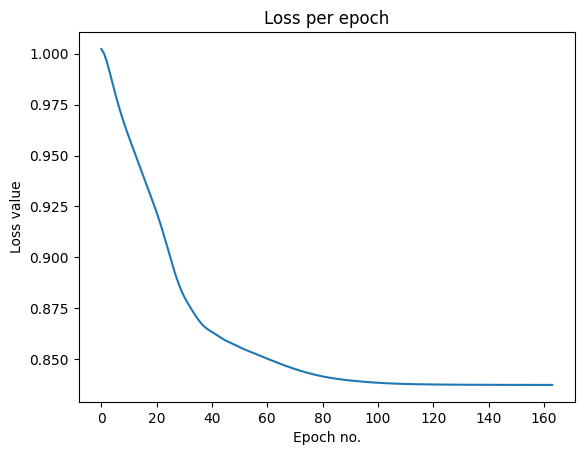

In [167]:
classifier.fit(X_train, y_train)

In [149]:
classifier.score(X_test, y_test)

0.25